In [1]:
import os
import sys
import ast
import cv2
import json
import math
import shutil
import random
import pickle
import imageio
import numpy as np
import pandas as pd
from collections import defaultdict
from tqdm import tqdm
from pprint import pprint
from pandarallel import pandarallel
import matplotlib.pyplot as plt
sys.path.append('./')
from utils import normalize_image, get_sequences, plot_image, plot_images

In [5]:
# root_dir = '/data/jupiter/li.yu/data'
# root_dir = '/data/jupiter/datasets/'
# root_dir = '/data2/jupiter/datasets/'
root_dir = '/data3/jupiter/datasets/'
dataset = 'rev1_rgb_stereo_train_v1_0'
# dataset = 'dust_datasets/halo_human_in_dust_night_v3'
# dataset = 'productivity_datasets/productivity_set_general_080124_v0.3'
# dataset = 'humans/on_path_aft/on_path_aft_humans_day_2024_rev2_v16'
# dataset = 'nodar_datasets/sequence_day_no_dust_stationary'
# csv = os.path.join(root_dir, dataset, 'annotations.csv')
csv = os.path.join(root_dir, dataset, 'master_annotations_master.csv')
# csv = os.path.join(root_dir, dataset, 'master_annotations_full_cleaned_rev1_train_human_test_rev1_stops_20241011_fresh_labels_bugfix_micro_22k_dust_drop_gc_combine.csv')
# converters = {"label_map": ast.literal_eval, "label_counts": ast.literal_eval}
converters = {}
df = pd.read_csv(csv, converters=converters)
df.shape

/tmp/ipykernel_2648333/1819214180.py:15: DtypeWarning: Columns (0,6,7,21,30,33,45,47,48,49,50,51,53,54,55,56,57,59,60,61,62,63,64,65,66,68,69,70,72,74,75,76,77,78,80,81,82,83,85,86,88,89,90,92,94,95,96,97,98,100,101,102,103,105,106,108,109,110,111,112,114,115,116,117,118,120,121,122,123,124,128,129,130,132,134,135,136,137,138,140,141,142,143,145,146,148,149,150,152,154,155,157,158,160,161,162,163,165,166,168,169,170,172,174,175,176,177,178,180,181,182,183,185,186,188,189,190,192,194,195,196,197,198,200,201,202,203,205,206,208,209,210,212,214,215,216,217,218,220,221,222,223,225,226,229,230,232,233,234,241,242,243,245,246,250,251,252,254,257,259,260,261,262,263,264,265,266,267,269,270,273,274,275,279,283,286,287,288,289,290,291,292,293,295,296,297,298,302,303,304,305,306,307,308,310,312,313,314,315,316,317,319,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,353,354,355,356,357,358,359,360,361,362,364,366,369,370,371,

(329291, 486)

In [6]:
# df.groupby('special_notes').size()
df.groupby('camera_location').size()

camera_location
front-center-left    53194
front-left-left      48967
front-right-left     45103
rear-left            78242
side-left-left       48532
side-left-right         16
side-right-left      55237
dtype: int64

In [11]:
categorical_labels_map = {'objects_pixel_count': {'Utility pole', 'Immovable Objects', 'Buildings', 'Animals', 'Tile-Inlet'}, 
                          'humans_pixel_count': {'Humans'}, 'tractors_or_vehicles_pixel_count': {'Tractors or Vehicles'}, 
                          'dust_pixel_count': {'Heavy Dust'}, 'birds_pixel_count': {'Birds'}, 'airborne_debris_pixel_count': {'Airborne Debris'},
                          'unharvested_field_pixel_count': {'Unharvested Field'}, 'trees_pixel_count': {'Trees'}}
for key in categorical_labels_map:
    print(key, key in df)

objects_pixel_count True
humans_pixel_count True
tractors_or_vehicles_pixel_count True
dust_pixel_count True
birds_pixel_count True
airborne_debris_pixel_count True
unharvested_field_pixel_count True
trees_pixel_count True


## Show image

In [3]:
len(df.unique_id.unique()), len(df.id.unique()), df.rectified_stereo_output_height.unique(), df.rectified_stereo_output_width.unique()

(942, 630, array([512]), array([768, 512]))

In [4]:
pred_dir = f'/data/jupiter/li.yu/exps/driveable_terrain_model/11_3_rev1_train_human_test_dean_multires_ignore_trees_1p25_u_p5_h_p2_v_ft_from_rev1_22kdust_ft_p15dust_h_fresh_dust11/{dataset}'

# # load seg prediction
# pred_df = pd.read_csv(os.path.join(pred_dir, 'output.csv'))
# print(pred_df.shape)
# df = df.merge(pred_df.drop(columns=["id", "camera_location", "operation_time", "special_notes", "jdb_s3_path"]), on='unique_id')
# # pred_df['id'] = pred_df['unique_id']
# # df = df.merge(pred_df.drop(columns=["unique_id", "camera_location"]), on='id')
# print(df.shape)

# # load dust prediction
# # pred_df = pd.read_csv(os.path.join(pred_dir, 'dust_ratio.csv'))
# pred_df = pd.read_csv(os.path.join(pred_dir, 'iq_head_output.csv'))
# print(pred_df.shape)
# # df = df.merge(pred_df.drop(columns=["id"]), on='unique_id')
# df = df.merge(pred_df, on='unique_id')
# print(df.shape)

In [18]:
df2 = df[(df.result_state == 'false_positive') & (df.special_notes == 'weed spark said was human (8012 on 10/21 @3:53PM)')]
# df2 = df[(df['n_pred_dust-debris_pixels'] > 0.1) & (df.operation_time == 'daytime')]
# df2 = df[df['iq_head_prediction'] > 0]
# df2 = df[(df.operation_time == 'dawn_dusk') & (df.collected_on > '2024-01-01')]
# df2 = df[(df.camera_location == 'T13') & (df.camera_location_right == 'T15') & (df.collected_on.str.startswith('2024-07-30'))]
# df2 = df[df.id == '653465e64db7d79afd0cd61d']
# df2 = df[df.bag_name == 'loamy_799_0__10_21_2023-20_52_37']
# df2 = df[df.cluster_id == '0x12']
df2.shape

(2, 173)

65e9a9440c9c6f198971a69a T14 65e9a9470702dacc584c2b55 2024-02-27T21:13:32.829000


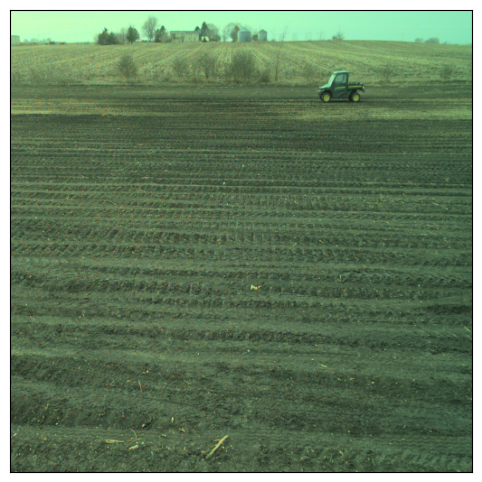

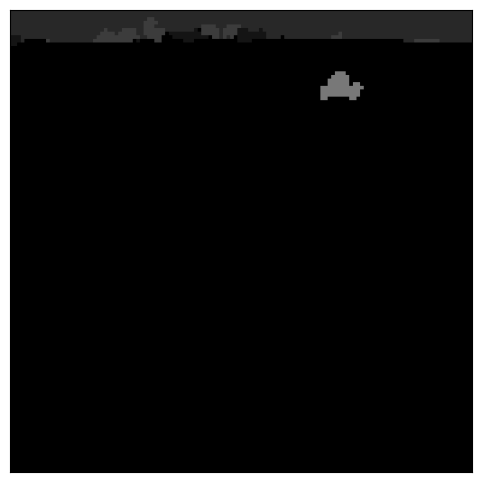

65e9e963504a4aaf5372ed11 T06 65e9e95be4305312190b6ebc 2024-02-27T21:13:23.627000


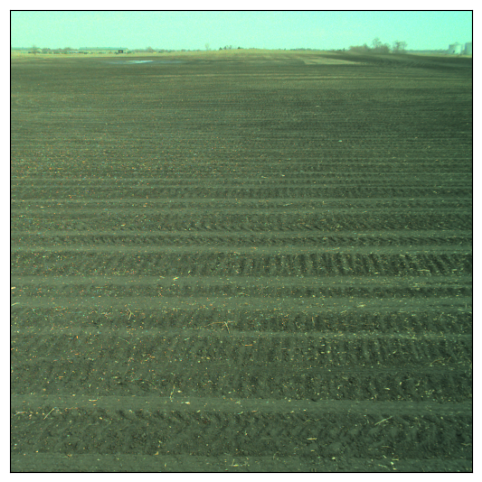

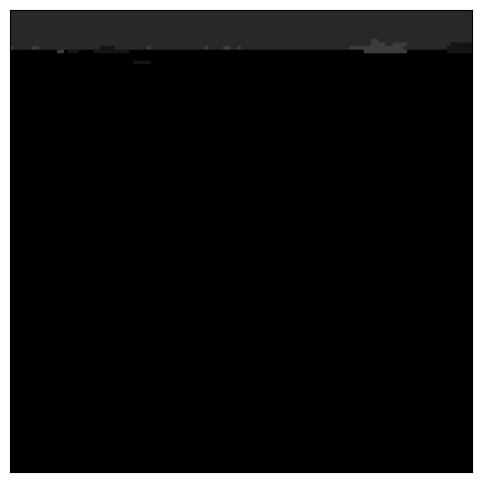

In [8]:
sub_df = df.sample(2)
show_image, show_label = True, False
show_debayered_rgb, show_raw_label = False, False
show_pred_result = True

for i, row in sub_df.iterrows():
    # print(row.unique_id, row.gt_dust_ratio, row.total_averaged_dust_conf)
    # print(row.unique_id, row.result_state)
    print(row.id, row.camera_location, row.id_right, row.collected_on)
    if show_image:
        data_path = os.path.join(root_dir, dataset, row.stereo_pipeline_npz_save_path)
        img = np.load(data_path)['left']
        img_norm = normalize_image(img, hdr_mode=row.hdr_mode, return_8_bit=True)
        plot_image(img_norm)

    if show_debayered_rgb:
        image = imageio.imread(os.path.join(root_dir, dataset, row.artifact_debayeredrgb_0_save_path))
        plot_image(image)
        # image = imageio.imread(f'{root_dir}/{dataset}/images/{row.id_right}/artifact_debayeredrgb_0_{row.id_right}.png')
        # plot_image(image)

    if show_label and 'rectified_label_save_path' in row and isinstance(row.rectified_label_save_path, str):
        label_path = os.path.join(root_dir, dataset, row.rectified_label_save_path)
        label = np.load(label_path)['left']
        labels, counts = np.unique(label, return_counts=True)
        label_strs = [row.label_map[str(i)] for i in labels if i != 0]
        print(row.unique_id, labels, counts, label_strs)
        # print(row.id, np.unique(label))
        plot_image(label)

    if show_raw_label:
        label = imageio.imread(os.path.join(root_dir, dataset, row.annotation_pixelwise_0_save_path))
        labels = np.unique(label)
        label_strs = [row.label_map[str(i)] for i in labels if i != 0]
        print(row.unique_id, labels, label_strs)
        plot_image(label)

    if show_pred_result:
        result_path = os.path.join(pred_dir, 'output_visualization', row.unique_id+'.png')
        if os.path.isfile(result_path):
            res_img = cv2.cvtColor(cv2.imread(result_path), cv2.COLOR_BGR2RGB) * 20
            plot_image(res_img, figsize=(20, 6))

        # # load left-right mask
        # result_path = os.path.join(lr_mask_dir, 'predicted_lr_masks', row.unique_id+'.npz')
        # lr_consistency_mask = np.load(result_path, allow_pickle=False)['lr_consistency_mask']
        # type(lr_consistency_mask), lr_consistency_mask.shape, lr_consistency_mask.max()
        # plot_image(lr_consistency_mask)

## Combine dust levels from left and right cameras

In [10]:
model_dir = '/data/jupiter/li.yu/exps/driveable_terrain_model/11_3_rev1_train_human_test_dean_multires_ignore_trees_1p25_u_p5_h_p2_v_ft_from_rev1_22kdust_ft_p15dust_h_fresh_dust11/'
dataset = 'dust_datasets/halo_human_in_dust_night_v3'
left_df = pd.read_csv(os.path.join(model_dir, f'{dataset}/dust_ratio.csv'))
right_df = pd.read_csv(os.path.join(model_dir, f'{dataset}_rightcam/dust_ratio.csv'))
left_df.shape, right_df.shape

((8878, 7), (8878, 7))

In [11]:
left_df['total_averaged_dust_conf_left'] = left_df['total_averaged_dust_conf']
right_df['total_averaged_dust_conf_right'] = right_df['total_averaged_dust_conf']
both_df = left_df[['unique_id', 'total_averaged_dust_conf_left']].merge(right_df[['unique_id', 'total_averaged_dust_conf_right']], on='unique_id')
both_df.sample(5)

,unique_id,total_averaged_dust_conf_left,total_averaged_dust_conf_right
3532,665fbde6167d5f2ee2060286_T10_T11,0.059847,0.154012
3068,66a931de11b92388a2414ae6_T02_T04,0.062214,0.041452
4511,665fade93bf6acdaa7dd1c3e_T10_T11,0.257548,0.073493
7106,66a93887b5a3b96cff289dfd_T14_T15,0.038483,0.020812
758,665faf88b4b8480bd69dfa3b_T13_T15,0.230367,0.100486


In [12]:
both_df.to_csv(os.path.join(model_dir, f'{dataset}/dust_ratio_for_both_cameras.csv'), index=False)

## Look into Sample B data

In [12]:
# read in geohash table
geohash_table = '/data/jupiter/li.yu/data/halo_hard_cases/20240328_geohash_table_v8_1_rc.csv'
geohash_df = pd.read_csv(geohash_table)
geohash6_train_list = geohash_df[geohash_df.bucket == 'train'].geohash6.to_list()
geohash6_test_list = geohash_df[geohash_df.bucket == 'test'].geohash6.to_list()
print(geohash_df.shape, len(geohash6_train_list), len(geohash6_test_list))

(2101, 2) 1672 371


### Look at queried sample b data

In [31]:
# load all sample b data
all_sample_b_data = '/data/jupiter/li.yu/data/halo_hard_cases/all_mcap_data_till_0418.csv'
all_sb_df = pd.read_csv(all_sample_b_data)
# all_sb_df['serial_number'] = all_sb_df.calibration_data__json.apply(lambda x: json.loads(x).get('serial_number', np.nan))
# all_sb_df['sn7'] = all_sb_df['serial_number'].apply(lambda s: s[:7])
print(all_sb_df.shape)
print(all_sb_df['sn7'].unique())

net_sb_df = all_sb_df[all_sb_df.sn7 == 'PCE7T1B']
print(net_sb_df.shape)
# net_sb_df.to_csv('/data/jupiter/li.yu/data/halo_hard_cases/all_sample_b_data_till_0418.csv', index=False)

(9937422, 30)
['PCE7T1B' 'PCE7T1A']
(9020603, 30)


In [29]:
all_sb_geohash6_list = set(net_sb_df.geohash6.unique())
print(len(all_sb_geohash6_list))
print(len(all_sb_geohash6_list.intersection(geohash6_train_list)), len(all_sb_geohash6_list.intersection(geohash6_test_list)))
sb_geohash6_no_in_list = all_sb_geohash6_list - set(geohash6_train_list)
print(len(sb_geohash6_no_in_list))

46
22 0
24


In [30]:
sb_df_not_in_list = net_sb_df[net_sb_df.geohash6.isin(sb_geohash6_no_in_list)]
print(sb_df_not_in_list.shape)

(5059762, 30)


### Look at sample b data on harvest

In [5]:
df['serial_number'] = df.calibration_data.apply(lambda x: ast.literal_eval(x).get('serial_number', np.nan))
df['sn7'] = df['serial_number'].apply(lambda s: s[:7])
df['geohash6'] = df['geohash'].apply(lambda s: s[:6])
df['sn7'].unique(), df['geohash6'].unique()

(array(['PCE7T1A', 'INVALID', 'PCE7T1B'], dtype=object),
 array(['9xjg3x', '9xjg3r', '9xjg98', ..., '9zsc1n', 'dp0h01', 'dp08v2'],
       dtype=object))

In [6]:
sbdf = df[df.sn7 == 'PCE7T1B']
print(sbdf.shape)

(10609, 362)


In [7]:
sbdf.groupby(['geohash6', 'collected_on_day']).size()

geohash6  collected_on_day
9q9d4w    2024-02-13           314
          2024-02-14           207
          2024-02-20             2
          2024-03-07             4
          2024-03-11             1
          2024-03-12            31
9q9d4x    2024-02-20            19
          2024-02-21             1
          2024-02-22             4
          2024-03-07             4
9q9d4y    2024-02-20             7
9q9d4z    2024-02-07            21
          2024-02-13             6
          2024-02-15             2
          2024-02-16             2
          2024-03-05             3
9ufs6t    2024-02-08           549
9ufs6v    2024-02-08           348
9ufs6w    2024-02-07           934
          2024-02-08           240
9ufs6x    2024-02-07          1332
          2024-02-08            27
9ufs6y    2024-02-07          1026
          2024-02-08            64
9ufs6z    2024-02-07           396
          2024-02-08             8
9ufsd7    2024-02-06            22
          2024-02-07        

In [69]:
# select subdf by geohash
df2 = sbdf[sbdf.geohash6.str.startswith('9zmt8e')]
print(df2.shape)
df2.terrain_type.unique()

(3868, 366)


array([nan], dtype=object)

In [145]:
# select subdf by label category
# sbdf['Trees'] = sbdf['label_counts'].apply(lambda lc: lc.get('Trees', 0))
# sbdf['Sky'] = sbdf['label_counts'].apply(lambda lc: lc.get('Sky', 0))
# sbdf['Road'] = sbdf['label_counts'].apply(lambda lc: lc.get('Road', 0))
# sbdf['Birds'] = sbdf['label_counts'].apply(lambda lc: lc.get('Birds', 0))
# sbdf['Utility Pole'] = sbdf['label_counts'].apply(lambda lc: lc.get('Utility Pole', 0))
# sbdf['Roadside Buffer'] = sbdf['label_counts'].apply(lambda lc: lc.get('Roadside Buffer', 0))
sbdf['Heavy Dust'] = sbdf['label_counts'].apply(lambda lc: lc.get('Heavy Dust', 0))

df2 = sbdf[(sbdf['Heavy Dust'] > 50000)]
print(df2.shape)

(21, 370)


In [154]:
# df['Roadside Buffer'] = df['label_counts'].apply(lambda lc: lc.get('Roadside Buffer', 0))
# df['Flooded Area'] = df['label_counts'].apply(lambda lc: lc.get('Flooded Area', 0))

df2 = df[(df['Roadside Buffer'] > 1000)]
print(df2.shape)

(135950, 361)


In [79]:
sbdf.iloc[0].label_counts

{'unlabelled': 38,
 'Untilled field': 313118,
 'Road': 655,
 'Roadside Buffer': 5681,
 'Utility Pole': 763,
 'Trees': 10450,
 'Sky': 8577,
 'Immovable Objects': 661,
 'Tractors or Vehicles': 11643,
 'Humans': 1240,
 'Implement': 34889,
 'Ego Tractor': 5501}

In [156]:
id = '651f586e7747a76b7ba779a8'
df3 = df[df.id == id]
# df3 = df2[df2.id == id]
print(df3.shape)
df3.iloc[0].collected_on

(1, 361)


'2023-10-02T17:39:21.561000'

In [157]:
# terrains = {}
# category = 'open_field'
# category = 'in_farm'
# category = 'trees'
# category = 'pole_by_road'
# category = 'birds'
# category = 'dust'
# category = 'head_lands'  # aft day human
# category = 'tall_weeds'  # forward day human
# category = 'irrigation'  # forward day human
# category = 'road_side'  # forward day human
# category = 'tall_weeds2'  # train set
# category = 'flooded_area'  # train set
# category = 'head_lands2' 
# category = 'head_lands3' 
category = 'open_field2'
terrains[category] = {'id': id, 'collected_on': df3.iloc[0].collected_on, 'bag_name': df3.iloc[0].bag_name}
print(len(terrains), terrains)

15 {'open_field': {'id': '65eb4802738e53d66c8f346a', 'collected_on': '2024-02-08T19:22:19.435000', 'bag_name': '02_08_2024-19_22_27'}, 'in_farm': {'id': '65fb4c39ae44446ff5d3fc19', 'collected_on': '2024-02-23T21:18:43.051000', 'bag_name': '02_23_2024-21_18_45'}, 'trees': {'id': '65eb1913abb27b5979bb2c49', 'collected_on': '2024-02-07T18:28:11.093000', 'bag_name': '02_07_2024-18_28_20'}, 'pole_by_road': {'id': '65fb5e03fbbd37ea5e01a225', 'collected_on': '2024-03-13T20:51:54.666000', 'bag_name': '03_13_2024-20_51_45'}, 'birds': {'id': '65fb3f89c7d378dbc65eb080', 'collected_on': '2024-03-13T21:12:48.755000', 'bag_name': '03_13_2024-21_12_45'}, 'head_lands': {'id': '6516a9ee59d4a80830b8f3f2', 'collected_on': '2023-09-20T18:58:52.347000', 'bag_name': '09_20_2023-18_58_23'}, 'tall_weeds': {'id': '64e5d2fd7d3e736bc96a7e64', 'collected_on': '2023-08-15T21:09:17.073000', 'bag_name': '08_15_2023-21_09_14'}, 'irrigation': {'id': '653b8ab65516ee030864597f', 'collected_on': '2023-10-20T20:58:56.0800

In [164]:
terrains.keys()

dict_keys(['open_field', 'in_farm', 'trees', 'pole_by_road', 'birds', 'head_lands', 'tall_weeds', 'irrigation', 'road_side', 'tall_weeds2', 'dust', 'flooded_area', 'head_lands2', 'head_lands3', 'open_field2'])

In [162]:
terrains_d = {'id': [], 'collected_on': [], 'bag_name': [], 'terrain': []}
for c in terrains:
    terrains_d['id'].append(terrains[c]['id'])
    terrains_d['collected_on'].append(terrains[c]['collected_on'])
    terrains_d['bag_name'].append(terrains[c]['bag_name'])
    terrains_d['terrain'].append(c)
terrains_df = pd.DataFrame(data=terrains_d)
print(terrains_df.shape)
terrains_df.to_csv('/data/jupiter/li.yu/data/dune_simulation/representative_terrains.csv', index=False)

(15, 4)


## Get categorical labels for training set

In [11]:
categorical_labels_map = {'objects_pixel_count': {'Utility pole', 'Immovable Objects', 'Buildings', 'Animals', 'Tile-Inlet'}, 
                          'humans_pixel_count': {'Humans'}, 'tractors_or_vehicles_pixel_count': {'Tractors or Vehicles'}, 
                          'dust_pixel_count': {'Heavy Dust'}, 'birds_pixel_count': {'Birds'}, 'airborne_debris_pixel_count': {'Airborne Debris'},
                          'unharvested_field_pixel_count': {'Unharvested Field'}, 'trees_pixel_count': {'Trees'}}
cats = list(categorical_labels_map.keys())
categorical_object_labels = {v for k,vs in categorical_labels_map.items() for v in vs}
cats, categorical_object_labels

(['objects_pixel_count',
  'humans_pixel_count',
  'tractors_or_vehicles_pixel_count',
  'dust_pixel_count',
  'birds_pixel_count',
  'airborne_debris_pixel_count',
  'unharvested_field_pixel_count',
  'trees_pixel_count'],
 {'Airborne Debris',
  'Animals',
  'Birds',
  'Buildings',
  'Heavy Dust',
  'Humans',
  'Immovable Objects',
  'Tile-Inlet',
  'Tractors or Vehicles',
  'Trees',
  'Unharvested Field',
  'Utility pole'})

In [12]:
def get_categorical_labels(root_dir, dataset, row):
    # # raw label
    # label = imageio.imread(os.path.join(root_dir, dataset, row.annotation_pixelwise_0_save_path))
    # rectified label
    label_path = os.path.join(root_dir, dataset, row.rectified_label_save_path)
    label = np.load(label_path)['left']
    labels = np.unique(label)
    label_str_2_id = {row.label_map[str(i)]: i for i in labels if i != 0}
    # print(row.unique_id, label.shape, labels, label_str_2_id)
    # process object class
    for object_label, subs in categorical_labels_map.items():
        object_ids = [label_str_2_id[sub] for sub in subs if sub in label_str_2_id]
        object_pixel_count = 0
        if len(object_ids) > 0:
            object_pixel_count = np.count_nonzero(np.isin(label, object_ids))
        row[object_label] = object_pixel_count
    return row

# get_categorical_labels(root_dir, dataset, df.iloc[100])

In [15]:
# df = df.apply(lambda row: get_categorical_labels(root_dir, dataset, row), axis=1)
# pandarallel.initialize(nb_workers=8, progress_bar=True)
# df = df.parallel_apply(lambda r: get_categorical_labels(root_dir, dataset, r), axis=1)
print(df.shape)
df.to_csv(os.path.join(root_dir, dataset, 'master_annotations_full_cleaned_rev1_train_human_test_rev1_stops_wlc.csv'), index=False)
df[['unique_id'] + cats].to_csv('/data/jupiter/li.yu/data/halo_rgb_stereo_train_test/train_v11_1_categorical_count.csv', index=False)

(845447, 669)


In [6]:
# count_df = pd.read_csv('/data/jupiter/li.yu/data/Jupiter_train_v6_2/train_v6_2_birds_airborne_categorical_count.csv')
# count_df = pd.read_csv('/data/jupiter/li.yu/data/halo_rgb_stereo_train_test/train_v6_1_categorical_count.csv')
count_df = pd.read_csv('/data/jupiter/li.yu/data/halo_rgb_stereo_train_test/test_v6_1_categorical_count.csv')
# count_df = df[['unique_id'] + cats]
print(count_df.shape)
count_df.head(2)

(50864, 7)


,unique_id,objects,humans,vehicles,dust,birds,airborne
0,64cfdb12ccc434d8f6bf9808_T01_T03,241,0,0,0,0,0
1,64cfdc6ae578ee9334a30426_T01_T03,17184,0,0,0,0,0


In [8]:
categorical_labels = [['objects', 50], ['humans', 50], ['vehicles', 200], ['dust', 1000], ['birds', 50], ['airborne', 50]]
for cat, thres in categorical_labels:
    cat_count_df = count_df[count_df[cat] > thres]
    print(f'{cat}: # images {len(cat_count_df)}, {len(df) / len(cat_count_df):.1f}, quantile 90% pixel count {cat_count_df[cat].quantile(q=0.9):.0f}')
    # cat_count_df[cat].hist(bins=100)
    # plt.show()

objects: # images 38270, 1.3, quantile 90% pixel count 33235
humans: # images 16346, 3.1, quantile 90% pixel count 30092
vehicles: # images 8386, 6.1, quantile 90% pixel count 101172
dust: # images 4523, 11.2, quantile 90% pixel count 359313
birds: # images 1478, 34.4, quantile 90% pixel count 7009
airborne: # images 1923, 26.5, quantile 90% pixel count 5134


In [22]:
pred_dir = '/data/jupiter/li.yu/exps/driveable_terrain_model/'
# seg_model = 'v61_7cls_dustaugonhuman_dlbase_0109'
seg_model = 'ds_v6_1_4x_human'
pred_df = pd.concat([pd.read_csv(f'{pred_dir}/{seg_model}/{dataset}_640/output.csv'), pd.read_csv(f'{pred_dir}/{seg_model}/{dataset}_768/output.csv')], ignore_index=True)
print(pred_df.shape)
pred_df.head(1)

(50864, 11)


,unique_id,id,camera_location,operation_time,special_notes,jdb_s3_path,state,human_state,vehicle_state,min_pixels_threshold,features
0,64cfde4981c0f0db5eaa1f29_T02_T03,64cfde4981c0f0db5eaa1f29,T02,daytime,first headland pass,s3://blueriver-jupiter-data/continuous/halohit...,true_negative,NaN,NaN,50,"{""large_object_pixels"": 16, ""large_object_min_..."


In [19]:
def get_results(count_df, res_df, binary_category=True, only_2cls=True):
    print(f'category gt_count pred_count matched')
    if binary_category:
        if only_2cls:
            categorical_labels = [['birds', 25], ['airborne', 50]]
        else:
            categorical_labels = [['objects', 50], ['humans', 50], ['vehicles', 200], ['dust', 1000], ['birds', 25], ['airborne', 50]]
        for cat, thres in categorical_labels:
            cat_count_df = count_df[count_df[cat] > thres]
            cat_res_df = res_df[res_df[cat] > 0.5]
            cat_correct_df = cat_count_df[cat_count_df.unique_id.isin(cat_res_df.unique_id)]
            print(cat, len(cat_count_df), len(cat_res_df), len(cat_correct_df))
    else:
        if only_2cls:
            categorical_labels = [['birds', 2256], ['airborne', 5477]]
        else:
            categorical_labels = [['objects', 24664], ['humans', 31081], ['vehicles', 131716], ['dust', 360000], ['birds', 2256], ['airborne', 5477]]
        percent_thres = 0.005
        for cat, thres in categorical_labels:
            cat_count_df = count_df[(count_df[cat] / thres) > percent_thres]
            cat_res_df = res_df[res_df[cat] > percent_thres]
            cat_correct_df = cat_count_df[cat_count_df.unique_id.isin(cat_res_df.unique_id)]
            print(cat, len(cat_count_df), len(cat_res_df), len(cat_correct_df))

In [23]:
run_ids = [
    # 'v61_6cls_cat_0119',
    # 'v61_6cls_cat_0120',
    'v61_6cls_posw_cat_0120',
    # 'v61_2cls_bin_cat_0122',
    'v61_wirev1_6cls_bin_cat_0123',
    # 'v61_6cls_np90_cat_0120',
    # 'v61_6cls_np90_posw_cat_0120',
    # 'v61_6cls_np90_cap_posw_cat_0120',
]
for run_id in run_ids:
    print(run_id)
    res_df = pd.read_csv(f'/data/jupiter/li.yu/exps/driveable_terrain_model/{run_id}/halo_rgb_stereo_test_v6_1/output.csv')
    get_results(count_df, res_df, binary_category = not 'np90' in run_id, only_2cls=False)
    print()

v61_6cls_posw_cat_0120
category gt_count pred_count matched
objects 38270 41483 35459
humans 16346 11955 11191
vehicles 8386 10113 5125
dust 4523 4843 3516
birds 1511 622 527
airborne 1923 2044 689

v61_wirev1_6cls_bin_cat_0123
category gt_count pred_count matched
objects 38270 41626 35837
humans 16346 15450 13823
vehicles 8386 12608 6478
dust 4523 5071 3722
birds 1511 1924 958
airborne 1923 1751 783



In [18]:
cat = 'birds'
cat_count_df = count_df[count_df[cat] > thres]
cat_res_df = res_df[res_df[cat] > 0.5]
cat_pred_df = pred_df[pred_df.state == 'true_positive']
cat_correct_df = cat_count_df[cat_count_df.unique_id.isin(cat_res_df.unique_id)]
cat_pred_correct_df = cat_count_df[cat_count_df.unique_id.isin(cat_pred_df.unique_id)]
print(cat, len(cat_count_df), len(cat_res_df), len(cat_correct_df), len(cat_pred_df), len(cat_pred_correct_df))

birds 1478 1924 949 5297 709


In [41]:
cat = 'airborne'
cat_count_df = count_df[count_df[cat] > thres]
cat_res_df = res_df[res_df[cat] > 0.5]
cat_rectify_df = pred_df[(pred_df.state == 'true_positive') | (pred_df.state == 'false_negative')]
cat_pred_df = pred_df[(pred_df.state == 'true_positive')]
cat_correct_df = cat_res_df[cat_res_df.unique_id.isin(cat_rectify_df.unique_id)]
cat_pred_correct_df = cat_count_df[cat_count_df.unique_id.isin(cat_pred_df.unique_id)]
print(cat, len(cat_count_df), len(cat_res_df), len(cat_correct_df), len(cat_rectify_df), len(cat_pred_correct_df))

airborne 1923 1751 538 937 603


## Search around airborne debris images in training set to add more such data

In [29]:
df[['unique_id', 'has_airborne']].groupby('has_airborne').count()

,unique_id
has_airborne,
False,267657
True,12907


In [30]:
ab_df = df[df.has_airborne == True]
print(ab_df.shape, ab_df.iloc[0].geohash)

(12907, 348) 9xjgd16r9gj0


In [31]:
ab_df["geohash_6"] = ab_df["geohash"].apply(lambda x: x[:6])
total_geo_counts = ab_df["geohash_6"].value_counts()
print(total_geo_counts.shape)

(558,)


<ipython-input-31-10d40a88c582>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ab_df["geohash_6"] = ab_df["geohash"].apply(lambda x: x[:6])


In [32]:
total_geo_counts.head(4)

dp03k2    504
dp03hp    461
dp03k3    382
dp03k6    297
Name: geohash_6, dtype: int64

In [33]:
ab_df[ab_df.geohash_6 == 'dp03k2'][['unique_id', 'collected_on_day']].groupby('collected_on_day').count()

,unique_id
collected_on_day,
2023-09-11 00:00:00.000,90
2023-09-12 00:00:00.000,370
2023-09-13 00:00:00.000,43
2023-09-14 00:00:00.000,1


In [40]:
geohash_6_limit = 500
geohash_6_expand = 1.5
surround_ids = 0
for geohash_6 in ab_df.geohash_6.unique():
    collected_on_days = ab_df[(ab_df.geohash_6 == geohash_6)].collected_on_day.unique()
    for collected_on_day in collected_on_days:
        current = len(ab_df[(ab_df.geohash_6 == geohash_6) & (ab_df.collected_on_day == collected_on_day)].unique_id.unique())
        expand = int(geohash_6_limit / current * geohash_6_expand)
        if expand < 50:
            expand = 50
        elif expand > 500:
            expand = 500
        surround_ids += expand
        # # check how many images actually contain airborne debris
        # sub_df = cat_df[(cat_df.geohash.str.startswith(geohash_6)) & (cat_df.collected_on.str.startswith(collected_on_day[:10]))]
        # if len(sub_df) > 0:
        #     print(geohash_6, collected_on_day, expand, len(sub_df))
surround_ids

187650

In [58]:
ab_df[(ab_df.geohash_6 == '9zpuut') & (ab_df.hard_drive_name == 'JUPD-156_2023-10-23')][['unique_id', 'collected_on_day']].groupby('collected_on_day').count()

,unique_id
collected_on_day,
2023-11-03 00:00:00.000,18
2023-11-04 00:00:00.000,1
2023-11-05 00:00:00.000,10
2023-11-06 00:00:00.000,18
2023-11-07 00:00:00.000,3


## Look into searched birds data

In [4]:
# pred_dir = '/data/jupiter/li.yu/exps/driveable_terrain_model/20676_r2_rgb_bigdecay_biglr/halo_rgb_stereo_sample_train_2000'
# pred_dir = '/data/jupiter/li.yu/exps/driveable_terrain_model/20676_r2_rgb_bigdecay_biglr/halo_rgb_stereo_test_v6_1'
# pred_dir = '/data/jupiter/li.yu/exps/driveable_terrain_model/v81_nextvitsmall_dust_only_kore_dean_0406/20240312_2_million_for_model_positive_pipeline_part_0_stereo'
pred_dir = '/data/jupiter/li.yu/exps/driveable_terrain_model/v61_wirev1_6cls_bin_cat_0123/20240312_2_million_for_model_positive_pipeline_part_0_stereo'
# pred_dir = '/data/jupiter/li.yu/exps/driveable_terrain_model/v61_wirev1_6cls_bin_cat_0123/halo_potential_birds_from_train_8_1'
pred_df = pd.read_csv(os.path.join(pred_dir, 'output.csv'))
print(pred_df.shape)

(294015, 7)


In [5]:
pred_df.head(2)

,unique_id,objects,humans,vehicles,dust,birds,airborne
0,64bffbaa9e38f0c37083dab5,0.046179,0.000234,0.019709,0.999979,0.006457,0.016716
1,64d27369f32c2602c3a46642,0.074155,0.018350,0.001946,0.067804,0.001568,0.000324


In [8]:
# df2 = pred_df[(pred_df.birds > 0.5) | (pred_df.airborne > 0.5)]
df2 = pred_df[(pred_df.birds > 0.8)]
print(df2.shape)

(4102, 7)


In [12]:
df2.sample(5).unique_id.to_list()

['64d5d8394210b6d080e2d46a',
 '64d569276ee204e8591ea461',
 '64f2adee61804b5d0b0609fc',
 '64f1ae9fe4c6387b4488404c',
 '64f1850cadb96901703ba9f8']

In [ ]:
ids = ['64d65495cdddad3864c0dcb4', '64f1a3449fb5ba71df70b71f', '']

## Debug cutnpaste presampling

In [22]:
sys.path.append('/home/li.yu/code/JupiterCVML/europa/base/src/europa')
from dl.dataset.cutnpaste_presampling import pre_sampling_for_cutnpaste

In [19]:
print(c2)

['brightness', 'label_counts', 'Airborne-debris', 'Driveable', 'humans_pixel_count', 'humans_max_row', 'humans_min_row', 'humans_max_col', 'humans_min_col', 'is_multi_human', 'is_standing_human', 'is_laying_down_human', 'occluded_humans', 'tractors_or_vehicles_pixel_count', 'tractors_or_vehicles_max_row', 'tractors_or_vehicles_min_row', 'tractors_or_vehicles_max_col', 'tractors_or_vehicles_min_col', 'unique_id']


In [23]:
cutnpaste_aug_params = {    
    'humans': {'blend_mode': 'vanilla', 'brightness_range': 0.05, 'cutout_rate': 0.5, 'depth_aware': False,
      'jitter_object': False, 'jitter_range': 0.15, 'laying_down_max_pixels': 15000, 'laying_down_min_pixels': 50,
      'max_cutout': 0.6, 'max_pixels': 1000000, 'min_pixels': 20, 'only_non_occluded': True,
      'rotate_degree': 30, 'rotate_object': True, 'same_brightness': True, 'same_operation_time': False,
      'sample_ratio': 0.4, 'standing_max_pixels': 100000, 'standing_min_pixels': 20, 'use_laying_down_human': True,
      'use_multi_human': True, 'use_standing_human': True},
}
outer = {    
    'preparer': {
      'classes': ['Humans', 'Tractors or Vehicles'],
      'human_non_standing_aspect_ratio_threshold': 0.5,
      'load_from_aug_csv': '/data/jupiter/li.yu/data/halo_rgb_stereo_train_test/train_v8_1_80k_cutnpaste.csv',
      'num_cutnpaste_samples': 150,
      'num_workers': 16,
      'save_to_aug_csv': '/data/jupiter/li.yu/data/halo_rgb_stereo_train_test/train_v8_1_80k_cutnpaste.csv'},
    'use': True,
    'vehicles': {'blend_mode': 'vanilla', 'brightness_range': 0.05, 'cutout_rate': 0.0, 'depth_aware': False,
      'jitter_object': False, 'jitter_range': 0.15, 'max_cutout': 0.6, 'max_pixels': 1000000,
      'min_pixels': 20, 'only_non_occluded': True, 'rotate_degree': 30, 'rotate_object': True,
      'same_brightness': True, 'same_operation_time': False, 'sample_ratio': 0.25},
}

dataframe_cnp = pre_sampling_for_cutnpaste(
    df,
    cutnpaste_aug_params,
    k_fixed_samples=100,
    num_workers=4,
    cache_dir='/data2/jupiter/datasets/halo_rgb_stereo_train_v8_1',
)
dataframe_cnp.shape

In [6]:
df[['unique_id', 'rectified_stereo_output_width']].groupby('rectified_stereo_output_width').count()

,unique_id
rectified_stereo_output_width,
640,116512
768,208971


In [4]:
# df['unique_id_len'] = df['unique_id'].apply(lambda s: len(s))
gdf = df[df.rectified_stereo_output_width > 0]
bdf = df[~df.unique_id.isin(gdf.unique_id)]
gdf.shape, bdf.shape

((325483, 393), (0, 393))

In [61]:
bdf['unique_id_len'] = bdf['unique_id'].apply(lambda s: len(s))

In [54]:
bdf = df[~df.unique_id.isin(gdf.unique_id)]

In [60]:
bdf[['unique_id', 'rectified_stereo_output_width', 'camera_location', 'camera_location_right']]

,unique_id,rectified_stereo_output_width,camera_location,camera_location_right
325927,617bc59766af5962349ef679,NaN,front-center-left,NaN
325928,6171b92bac1e069b248708fb,NaN,side-right-left,NaN
325929,61c43d42a11c7feb8256d642,NaN,side-left-left,NaN
325930,61c43643909d1e70f764a90c,NaN,rear-left,NaN
325931,61344883574551f3f04529ca,NaN,front-left-left,NaN
...,...,...,...,...
345768,611c62ebe7dbf9dc3e4e0f3d,NaN,front-right-left,NaN
345769,61c2b6ba7edfc3149e4326e4,NaN,rear-left,NaN
345770,61e2663ec8f15657a285c831,NaN,side-right-left,NaN
345771,6152e22932272a54ed9ff97a,NaN,front-right-left,NaN


In [64]:
df.loc[df.rectified_stereo_output_width.isna(), "rectified_stereo_output_width"] = 1024
df.loc[df.camera_location_right.isna(), "camera_location_right"] = bdf.camera_location.apply(lambda s: s[:-4]+'right')
df.to_csv(csv, index=False)

## Add subset from rev1 to rev2 training

In [13]:
# get dust images from rev1 training set
# rev1_train_csv = '/data2/jupiter/datasets/Jupiter_train_v6_2/master_annotations_20231019_clean_fl05.csv'
rev1_train_csv = '/data2/jupiter/datasets/Jupiter_train_v6_2/master_annotations.csv'
rev1_train_df = pd.read_csv(rev1_train_csv)
print(rev1_train_df.shape)
# load label count csv
rev1_train_label_count_csv = '/data/jupiter/li.yu/data/rev1_train/Jupiter_train_v6_2/train_v6_2_categorical_count_rectified.csv'
rev1_train_label_count_df = pd.read_csv(rev1_train_label_count_csv)
print(rev1_train_label_count_df.shape)
rev1_train_df = rev1_train_df.merge(rev1_train_label_count_df.drop(columns=['humans_pixel_count', 'tractors_or_vehicles_pixel_count']), on='unique_id')
print(rev1_train_df.shape)

/home/li.yu/anaconda3/envs/pytorchlightning/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (6,7,39,58,59,60,61,63,64,65,66,67,68,69,70,71,72,73,75,76,77,78,80,81,82,83,84,85,86,87,88,89,90,109,110,111,112,114,115,116,117,118,119,120,121,122,123,124,143,144,145,146,148,149,150,151,152,153,154,155,156,157,158,160,161,162,163,165,166,167,168,169,170,171,172,173,174,175,177,178,179,180,182,183,184,185,186,187,188,189,190,191,192,223,225,227,230,247,251,254,255,261,262,263,267,308,319,324,327,337,338,346,354,370,371,373,374,376,377) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(321638, 424)
(321638, 7)
(321638, 428)


In [14]:
# rev1_train_dust_df = rev1_train_df[(rev1_train_df.dust_pixel_count > 0) & (rev1_train_df.humans_pixel_count > 0)]
rev1_train_dust_df = rev1_train_df[(rev1_train_df.dust_pixel_count > 0)]
print(rev1_train_dust_df.shape)
rev1_train_dust_df.groupby('operation_time').size()

(21461, 428)


operation_time
dawn_dusk     847
daytime      6489
nightime     6261
unknown      7829
dtype: int64

In [23]:
curr_overlap_df = df[df.unique_id.isin(rev1_train_df.unique_id)]
print(curr_overlap_df.shape)
rev1_train_dust_df_to_add = rev1_train_dust_df[rev1_train_dust_df.operation_time == 'nightime'].sample(3000)
rev1_train_dust_df_to_add = rev1_train_dust_df_to_add[~rev1_train_dust_df_to_add.unique_id.isin(curr_overlap_df.unique_id)]
print(rev1_train_dust_df_to_add.shape)
rev1_train_dust_df_to_add['stereo_pipeline_npz_save_path'] = rev1_train_dust_df_to_add['stereo_pipeline_npz_save_path'].apply(lambda p: p.replace('processed', 'processed_rev1'))
rev1_train_dust_df_to_add['rectified_label_save_path'] = rev1_train_dust_df_to_add['rectified_label_save_path'].apply(lambda p: p.replace('processed', 'processed_rev1'))
print(rev1_train_dust_df_to_add.shape)

(10036, 1006)
(2992, 428)
(2992, 428)


In [24]:
for i,row in rev1_train_dust_df_to_add.sample(5).iterrows():
    print(row.id, row.stereo_pipeline_npz_save_path, row.rectified_label_save_path)

634e7d650f26ec984196a713 processed_rev1/images/634e7d650f26ec984196a713/stereo_output.npz processed_rev1/images/634e7d650f26ec984196a713/rectification_output_63ee7565c8bfe9786cb2720b.npz
62855f291ef22a54f0665460 processed_rev1/images/62855f291ef22a54f0665460/stereo_output.npz processed_rev1/images/62855f291ef22a54f0665460/rectification_output_63a5ddad8941063fc3c99fcc.npz
635aae19f8aa9ae6551ae9ab processed_rev1/images/635aae19f8aa9ae6551ae9ab/stereo_output.npz processed_rev1/images/635aae19f8aa9ae6551ae9ab/rectification_output_63b8b0b20b7b5349fd5a7ea5.npz
606debf783a0cde20ceef5e9 processed_rev1/images/606debf783a0cde20ceef5e9/stereo_output.npz processed_rev1/images/606debf783a0cde20ceef5e9/rectification_output_61a0680fce74e6548f9a97b9.npz
606dee71a6345b24f5b0b9ee processed_rev1/images/606dee71a6345b24f5b0b9ee/stereo_output.npz processed_rev1/images/606dee71a6345b24f5b0b9ee/rectification_output_619f018e82c4df6eec37cc44.npz


In [25]:
df3 = pd.concat([df, rev1_train_dust_df_to_add], ignore_index=False)
print(df3.shape)
df3.to_csv(os.path.join(root_dir, dataset, 'master_annotations_more_drops_cleaned_20240611_rev1_lying_down_sitting_n_stop_events_n_night_dust_rev2_no_drops_w_label_counts_v2.csv'), index=False)

(478258, 1006)


## Addon data to training set

In [8]:
# addon_csv = '/data3/jupiter/datasets/dust_datasets/halo_human_in_dust_from_frodo_20241019/master_annotations.csv'
addon_csv = '/data3/jupiter/datasets/dust_datasets/rev2_model_positives_1016/master_annotations.csv'
addon_df = pd.read_csv(addon_csv)
print(addon_df.shape)

addon_df['stereo_pipeline_npz_save_path'] = addon_df['stereo_pipeline_npz_save_path'].apply(lambda p: p.replace('processed', 'processed_20241021_rev2_model_positives_1016'))
addon_df['rectified_label_save_path'] = addon_df['rectified_label_save_path'].apply(lambda p: p.replace('processed', 'processed_20241021_rev2_model_positives_1016'))

df = pd.concat([df, addon_df], ignore_index=True)
df.shape

(4819, 288)


(912943, 383)

In [80]:
df3.to_csv(os.path.join(root_dir, dataset, 'master_annotations_full_cleaned_rev1_train_human_test_rev1_stops_20241011_fresh_labels_bugfix_micro_22k_dust_drop_gc_combine_dropoldpolicy_dust_modelp.csv'), index=False)

In [69]:
bad_policies = ['640a7ccb2f9c3e40b1dee273', '6462a92d10503aeec14d6781', '64b6df41e96209bcbddbb1cd', '6324faa4d4f8c9b441d72a20']
df2 = df[(~df.annotation_pixelwise_0_label_policy.isin(bad_policies))]
print(df2.shape)
df3 = df2[(~df2.id.isin(ids))]
print(df3.shape)

(910978, 385)
(910967, 385)


In [74]:
df3.operation_time.unique(), df3.groupby('operation_time').size().to_dict()

(array(['daytime', 'nightime', 'dawn_dusk', 'unknown', nan, 'error'],
       dtype=object),
 {'dawn_dusk': 71376,
  'daytime': 494241,
  'error': 6,
  'nightime': 267592,
  'unknown': 49781})

In [77]:
df3.loc[df3['operation_time'] == 'error', 'operation_time'] = 'unknown'
df3.loc[df3['operation_time'].isna(), 'operation_time'] = 'unknown'

In [78]:
df3.operation_time.unique(), df3.groupby('operation_time').size().to_dict()

(array(['daytime', 'nightime', 'dawn_dusk', 'unknown'], dtype=object),
 {'dawn_dusk': 71376, 'daytime': 494241, 'nightime': 267592, 'unknown': 77758})

In [65]:
df['ambiguous'] = df['label_map'].apply(lambda l: 'Floating-objects' in l.values())
print(df.groupby('ambiguous').size())
df2 = df[df.ambiguous == True]
df2.annotation_pixelwise_0_label_policy.unique()

ambiguous
False    912933
True         10
dtype: int64


array([nan], dtype=object)

In [67]:
# ids += df2.id.to_list()
ids = list(set(ids))
len(ids)

428

In [55]:
df.iloc[0].label_map.values()

dict_values(['Tilled field', 'Untilled field', 'Road', 'Roadside Buffer', 'Utility pole', 'Trees', 'Sky', 'Immovable Objects', 'Buildings', 'Tractors or Vehicles', 'Humans', 'Animals', 'Ignore', 'implement', 'sweep', 'harrow_tine', 'basket', 'basket_marker', 'Ego Tractor', 'Implement_hitch', 'Light Artifacts', 'Heavy Dust', 'Birds', 'Tall Weeds', 'Airborne Debris', 'Cotton Debris', 'Object Lights', 'Flooded Area', 'Ego Reflective Surface', 'Ego Mirror Housing'])

In [36]:
policies = df.annotation_pixelwise_0_label_policy.unique()
for policy in policies:
    df2 = df[df.annotation_pixelwise_0_label_policy == policy]
    if len(df2) > 0:
        print(policy, df2.iloc[0].label_map)

647fca6323d27cf92884e948 {'1': 'Tilled field', '2': 'Untilled field', '3': 'Road', '4': 'Roadside Buffer', '5': 'Utility pole', '6': 'Trees', '7': 'Sky', '8': 'Immovable Objects', '9': 'Buildings', '10': 'Tractors or Vehicles', '11': 'Humans', '12': 'Animals', '13': 'Ignore', '14': 'implement', '15': 'sweep', '16': 'harrow_tine', '17': 'basket', '18': 'basket_marker', '19': 'Ego Tractor', '20': 'Implement_hitch', '21': 'Light Artifacts', '22': 'Heavy Dust', '23': 'Birds', '24': 'Tall Weeds', '25': 'Airborne Debris', '26': 'Cotton Debris', '27': 'Object Lights', '28': 'Flooded Area', '29': 'Ego Reflective Surface', '30': 'Ego Mirror Housing'}
663170d2c1904f71d2f36ef8 {'1': 'Tilled field', '2': 'Untilled field', '3': 'Road', '4': 'Roadside Buffer', '5': 'Utility Pole', '6': 'Trees', '7': 'Sky', '8': 'Immovable Objects', '9': 'Buildings', '10': 'Tractors or Vehicles', '11': 'Humans', '12': 'Animals', '13': 'Ignore', '14': 'Implement', '19': 'Ego Tractor', '21': 'Light Artifacts', '22': 'H

In [51]:
# df3 = df[df.annotation_pixelwise_0_label_policy == '6324faa4d4f8c9b441d72a20']
# df3 = df[df.annotation_pixelwise_0_label_policy.isna()]
print(df3.shape)
df3.iloc[0].id, df3.iloc[i].label_map

(41446, 384)


('64d4f495a4df5076f1c1847d',
 {'1': 'Tilled field',
  '2': 'Untilled field',
  '3': 'Road',
  '4': 'Roadside Buffer',
  '5': 'Utility Pole',
  '6': 'Trees',
  '7': 'Sky',
  '8': 'Immovable Objects',
  '9': 'Buildings',
  '10': 'Tractors or Vehicles',
  '11': 'Humans',
  '12': 'Animals',
  '13': 'Ignore',
  '14': 'Implement',
  '19': 'Ego Tractor',
  '21': 'Light Artifacts',
  '22': 'Heavy Dust',
  '23': 'Birds',
  '24': 'Tall Weeds',
  '25': 'Airborne Debris',
  '26': 'Cotton Debris',
  '27': 'Object Lights',
  '28': 'Flooded Area',
  '29': 'Ego Reflective Surface',
  '30': 'Ego Mirror Housing',
  '31': 'Unharvested Field',
  '32': 'Grain',
  '33': 'Combine',
  '34': 'Grain Cart',
  '35': 'Semi',
  '36': 'Trench',
  '37': 'Mound',
  '38': 'Heavy Brush',
  '39': 'Non Ego Implement'})

## Get a subset for dust head training

In [7]:
# get dust image percentage in rev1 training set
rev1_dust_train_csv = '/data/jupiter/li.yu/data/Jupiter_train_v4_71/dust_label.csv'
rev1_dust_train_df = pd.read_csv(rev1_dust_train_csv)
print(rev1_dust_train_df.shape)

(195289, 5)


In [8]:
rev1_dust_train_df.groupby('dust_label').size()

dust_label
dust                     6375
dust and dust_light      2053
dust_light              12881
no dust                173980
dtype: int64

In [12]:
df2 = df[df.dust_pixel_count > 0]
print(df2.shape)
df2.groupby(['operation_time']).size()

(71595, 739)


operation_time
dawn_dusk     1882
daytime      43310
nightime     13645
unknown      12723
dtype: int64

In [13]:
nodust_df = df[df.dust_pixel_count == 0]
dust_df = df[df.dust_pixel_count > 0]
dust_human_df = dust_df[dust_df.humans_pixel_count > 0]
dust_vehicle_df = dust_df[dust_df.tractors_or_vehicles_pixel_count > 0]
nodust_human_df = nodust_df[nodust_df.humans_pixel_count > 0]
nodust_vehicle_df = nodust_df[(nodust_df.humans_pixel_count == 0) & (nodust_df.tractors_or_vehicles_pixel_count > 0)]
nodust_other_df = nodust_df[(nodust_df.humans_pixel_count == 0) & (nodust_df.tractors_or_vehicles_pixel_count == 0)]
print(nodust_df.shape, dust_df.shape)
print(dust_human_df.shape, nodust_human_df.shape, dust_vehicle_df.shape, nodust_vehicle_df.shape, nodust_other_df.shape)

(822737, 739) (71595, 739)
(6159, 739) (172637, 739) (7835, 739) (70682, 739) (579405, 739)


In [14]:
dust_train_df = pd.concat([dust_df, nodust_human_df.sample(100000), nodust_vehicle_df.sample(35000), nodust_other_df.sample(252000)], ignore_index=True)
print(dust_train_df.shape, len(dust_train_df.unique_id.unique()))

(458595, 739) 458595


### Get a subset excluding heavy dust with human/vehicle images

In [4]:
# load separately computed label counts df
label_counts_csv = '/data/jupiter/li.yu/data/halo_rgb_stereo_train_test/train_v9_2_categorical_count.csv'
label_counts_df = pd.read_csv(label_counts_csv)
print(label_counts_df.shape)
label_counts_df.sample(1)

(385833, 9)


,unique_id,objects,humans,vehicles,dust,birds,airborne,unharvested_field,trees
240235,6581ea526e13c74240040031_T01_T03,0,190,0,0,0,0,0,17517


In [5]:
dust_human_vehicle_df = label_counts_df[(label_counts_df.dust > 0) & ((label_counts_df.humans > 0) | (label_counts_df.vehicles > 0))]
small_human_df = label_counts_df[(label_counts_df.humans > 0) & (label_counts_df.humans < 60)]
small_vehicle_df = label_counts_df[(label_counts_df.vehicles > 0) & (label_counts_df.vehicles < 100)]
small_object_df = label_counts_df[(label_counts_df.objects > 0) & (label_counts_df.objects < 60)]
small_tree_df = label_counts_df[(label_counts_df.trees > 0) & (label_counts_df.trees < 100)]
small_unharvested_field_df = label_counts_df[(label_counts_df.unharvested_field > 0) & (label_counts_df.unharvested_field < 100)]
dust_human_vehicle_df.shape, small_human_df.shape, small_vehicle_df.shape, small_object_df.shape, small_tree_df.shape, small_unharvested_field_df.shape

((3017, 9), (1819, 9), (7110, 9), (28524, 9), (3852, 9), (526, 9))

In [7]:
label_counts_df[(label_counts_df.objects > 0)].shape

(236303, 9)

In [6]:
dust_train_df = df[(~df.unique_id.isin(dust_human_vehicle_df.unique_id)) & (~df.unique_id.isin(small_human_df.unique_id)) & 
                    (~df.unique_id.isin(small_vehicle_df.unique_id)) & (~df.unique_id.isin(small_object_df.unique_id)) & 
                    (~df.unique_id.isin(small_tree_df.unique_id)) & (~df.unique_id.isin(small_unharvested_field_df.unique_id))]
df.shape, dust_train_df.shape

((385833, 981), (343119, 981))

In [15]:
dust_train_df.to_csv(os.path.join(root_dir, dataset, 'master_annotations_full_cleaned_rev1_train_human_test_rev1_stops_22kdust_20240924_459ksubset_for_dust_head.csv'), index=False)

## Find sequence given image id

In [104]:
def find_sequence_by_image_id(df, unique_id, N, save_dir):
    # get all sequences by camera pair
    seq_dfs = get_sequences(df, interval=50*50*50*60, per_camera_pair=True)  # break the data by intervals between sequences
    print(df.shape, '# of sequences', len(seq_dfs))
    # get that sequence
    camera_pair = unique_id[-7:]
    seq_df = None
    for _df in seq_dfs:
        if _df.iloc[0].camera_pair == camera_pair:
            seq_df = _df
            print('find the sequence with correct camera pair', seq_df.shape)
    if seq_df is None:
        return
    # get collected on
    row = seq_df[seq_df.unique_id == unique_id].iloc[0]
    print(row.id, row.collected_on)
    # get short sequence
    sub_df = seq_df[seq_df.collected_on <= row.collected_on]
    assert sub_df.iloc[-1].collected_on == row.collected_on
    print('get sub sequence at time before provided image', sub_df.shape)
    # save image
    os.makedirs(save_dir, exist_ok=True)
    for i in range(-N, 0):
        row = sub_df.iloc[i]
        data_path = os.path.join(root_dir, dataset, row.stereo_pipeline_npz_save_path)
        img = np.load(data_path)['left']
        img_norm = normalize_image(img, hdr_mode=True, return_8_bit=True)
        img_path = os.path.join(save_dir, f'img{i+N}_{row.unique_id}_dust_level_{row.total_averaged_dust_conf:.2f}.png')
        print(row.collected_on, img_path)
        cv2.imwrite(img_path, cv2.cvtColor(img_norm, cv2.COLOR_RGB2BGR))
        if i == -1:
            plot_image(img_norm)

(585, 153) # of sequences 3
find the sequence with correct camera pair (195, 155)
667c621f79de73c09b0e71ab 2024-06-17T21:44:49.036000
get sub sequence at time before provided image (88, 155)
2024-06-17T21:44:47.704000 /data/jupiter/li.yu/data/spark_events/for_spark_engagements/manny_in_dust_1/img0_667c6234650827f457fa7b33_T02_T04_dust_level_0.00.png
2024-06-17T21:44:48.037000 /data/jupiter/li.yu/data/spark_events/for_spark_engagements/manny_in_dust_1/img1_667c63a0f06aef0392a54348_T02_T04_dust_level_0.00.png
2024-06-17T21:44:48.370000 /data/jupiter/li.yu/data/spark_events/for_spark_engagements/manny_in_dust_1/img2_667c63b5968f68c52db6a31c_T02_T04_dust_level_0.00.png
2024-06-17T21:44:48.703000 /data/jupiter/li.yu/data/spark_events/for_spark_engagements/manny_in_dust_1/img3_667c6349e4e253241d4c39ae_T02_T04_dust_level_0.00.png
2024-06-17T21:44:49.036000 /data/jupiter/li.yu/data/spark_events/for_spark_engagements/manny_in_dust_1/img4_667c621f79de73c09b0e71ab_T02_T04_dust_level_0.00.png


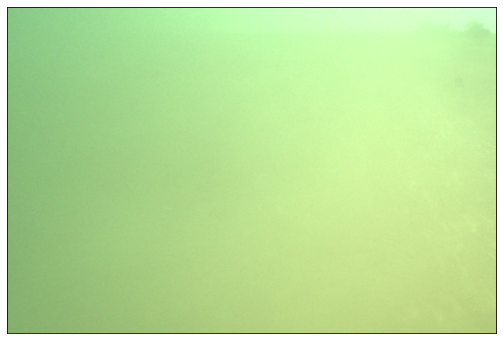

In [105]:
N = 5
save_dir = '/data/jupiter/li.yu/data/spark_events/for_spark_engagements'

# # box in dust
# unique_id = '667c5f5a0df30f8361ef13be_T02_T04'
# sub_dir = os.path.join(save_dir, 'box_in_dust')
# find_sequence_by_image_id(df, unique_id, N, sub_dir)

# half manny in dust
unique_id = '667c621f79de73c09b0e71ab_T02_T04'
sub_dir = os.path.join(save_dir, 'manny_in_dust_1')
find_sequence_by_image_id(df, unique_id, N, sub_dir)

# manny in dust
# unique_id = '66595c9fcc767a29c55c3d0b_T13_T15'  # manny_in_dust_day_1
# unique_id = '66597277916ffe827c688979_T14_T15'  # manny_in_dust_day_2
# unique_id = '6661296208707467156a4bbf_T10_T12'  # manny_in_dust_day_3
# unique_id = '66612753f41de441621eb0f3_T10_T12'  # manny_in_dust_day_4
# unique_id = '6660f32c79c72666e27038fa_T10_T11'  # manny_in_dust_day_5
# unique_id = '66612532d29364b6ba31df45_T10_T12'  # manny_in_dust_day_6
# unique_id = '6659727a5634b1b84bd06488_T13_T15'  # manny_in_dust_day_7
# unique_id = '66596e8efe138e3c73c37121_T14_T15'  # manny_in_dust_day_8
# unique_id = '6660f28279c72666e27036ff_T10_T11'  # manny_in_dust_day_9
# unique_id = '665faee53bf6acdaa7dd1f6d_T02_T03'  # manny_in_dust_night_1
# unique_id = '665fadb4210238339ce7b697_T14_T16'  # manny_in_dust_night_2
# unique_id = '665fc33fb4b8480bd69e179f_T02_T03'  # manny_in_dust_night_3
# unique_id = '665fc06b087074671566030b_T02_T03'  # manny_in_dust_night_4
# unique_id = '665fad13210238339ce7b448_T02_T03'  # manny_in_dust_night_5
# unique_id = '665fc1b8210238339ce7d77e_T13_T15'  # manny_in_dust_night_6
# unique_id = '66a937031e6ba18db4866294_T09_T11'  # manny_in_dust_night_7
# unique_id = '66a9353711b92388a2415e70_T10_T12'  # manny_in_dust_night_8
# unique_id = '66a93bb1e5bfbd5a8bb43c23_T10_T12'  # manny_in_dust_night_9
# unique_id = '665fb073087074671565ba1c_T13_T15'  # manny_in_dust_night_10
# unique_id = '66a93498236d482c28b10285_T09_T11'  # manny_in_dust_night_11
# unique_id = '6660f32c79c72666e27038fa_T10_T12'  # true_negative_day_1
# unique_id = '6660f314f5ffe7d6dbf6a3be_T10_T12'  # true_negative_day_2
# unique_id = '66596ec44cd992b0cf1ba93b_T14_T16'  # true_negative_day_3
# unique_id = '6660f2b3b5b4c40fa023f221_T10_T12'  # true_negative_day_4
# unique_id = '66612579579ccf8da18f5325_T10_T12'  # true_negative_day_5
# unique_id = '6660f32c79c72666e27038fa_T10_T12'  # true_negative_day_6
# unique_id = '665fc281587f8ad113c00a65_T02_T04'  # true_negative_night_1
# unique_id = '665fc07aad6a8b9401888a64_T14_T16'  # true_negative_night_2
# unique_id = '66a937a9d95513a8984bbf63_T02_T04'  # true_negative_night_3
# unique_id = '66a9350e2312cd9d226f5b7a_T02_T04'  # true_negative_night_4
# unique_id = '665fc3270aa0bf26ba6d8053_T02_T04'  # true_negative_night_5
# unique_id = '665fbf8425f8c9f2cbd7875b_T02_T04'  # true_negative_night_6
# sub_dir = os.path.join(save_dir, 'true_negative_night_6')
# find_sequence_by_image_id(df, unique_id, N, sub_dir)

## Prepare dataset for depth iq head training

In [9]:
# change reference processed folder 
def change_processed_folder(df, new_processed_name):
    # print(df.iloc[0].stereo_pipeline_npz_save_path, df.iloc[0].rectified_label_save_path, df.iloc[0].rectified_lidar_save_path)
    print(df.iloc[0].stereo_pipeline_npz_save_path)
    df['stereo_pipeline_npz_save_path'] = df['stereo_pipeline_npz_save_path'].apply(lambda p: p.replace('processed', new_processed_name))
    if 'rectified_label_save_path' in df:
        df['rectified_label_save_path'] = df['rectified_label_save_path'].apply(lambda p: p.replace('processed', new_processed_name))
    print(df.iloc[0].stereo_pipeline_npz_save_path)
    return df

In [12]:
# bad_dfs = []
# df = change_processed_folder(df, 'halo_buildup_dust_gilroy_medium_dust_iq_v2_processed')
bad_dfs.append(df)
bad_df = pd.concat(bad_dfs, ignore_index=True)
print(bad_df.shape)

(2128, 159)


In [22]:
# sample from training set to get good iq images
df2 = df[df.dust_pixel_count == 0]
print(df2.shape)
df3 = df2[df2.camera_location.str.startswith('T')]
# df3 = df2[df2.camera_location.isin(['T09', 'T10'])]
print(df3.shape)
df4 = df3.sample(10000)
df4.to_csv(os.path.join(root_dir, dataset, 'master_annotations_10k_nodust.csv'), index=False)

# good_df = df4
good_df = change_processed_folder(good_df, 'halo_rgb_stereo_train_v11_1_processed')
good_df.shape

processed/images/664249174fd8d0a886989fd6/stereo_output_T14_T15.npz
halo_rgb_stereo_train_v11_1_processed/images/664249174fd8d0a886989fd6/stereo_output_T14_T15.npz


(10000, 669)

In [23]:
# add iq label
bad_df['iq_label'] = 'buildup_dust'
good_df['iq_label'] = 'good'

In [ ]:
final_df = pd.concat([good_df, bad_df], ignore_index=True)
print(final_df.shape)
final_df.to_csv('/data/jupiter/datasets/dust_datasets/halo_buildup_dust_field_iq_triaged_v2/master_annotations_w_gilroy_medium_dust_w_rev2_10k_good_iq.csv', index=False)

/tmp/ipykernel_3550688/2517752190.py:1: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  final_df = pd.concat([good_df, bad_df], ignore_index=True)


(12128, 673)


In [45]:
# iq_pred_df = pd.read_csv('/data/jupiter/li.yu/exps/driveable_terrain_model/buildup_dust_v1_n_10k_rev2_iqhead_0903/halo_rgb_stereo_train_v11_1/iq_head_output.csv')
# iq_pred_df = pd.read_csv('/data/jupiter/datasets/dust_datasets/halo_buildup_dust_field_iq_triaged_v2/iq_head_output.csv')
# iq_pred_df = pd.read_csv('/data/jupiter/li.yu/exps/driveable_terrain_model/buildup_dust_v1_n_10k_rev2_iqhead_0903/dust_datasets/halo_buildup_dust_gilroy_low_dust_iq_v1/iq_head_output.csv')
iq_pred_df = pd.read_csv('/data/jupiter/li.yu/exps/driveable_terrain_model/buildup_dust_v1_n_10k_rev2_iqhead_0903/dust_datasets/halo_buildup_dust_gilroy_heavy_dust_human_iq_v1/iq_head_output.csv')
iq_pred_df.shape

(1652, 2)

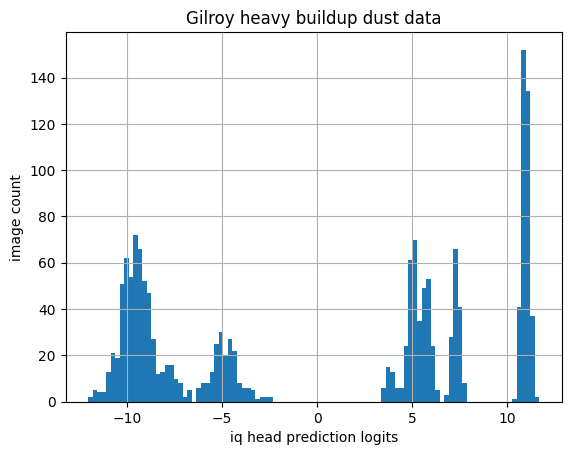

In [47]:
iq_pred_df.iq_head_prediction.hist(bins=100)
plt.xlabel('iq head prediction logits')
plt.ylabel('image count')
plt.title('Gilroy heavy buildup dust data')
plt.show()

In [48]:
iq_pred_df[iq_pred_df.iq_head_prediction > 0].shape[0] / iq_pred_df.shape[0]

0.5326876513317191

In [30]:
final_df = final_df.merge(iq_pred_df, on='unique_id')
final_df.shape

(12128, 674)

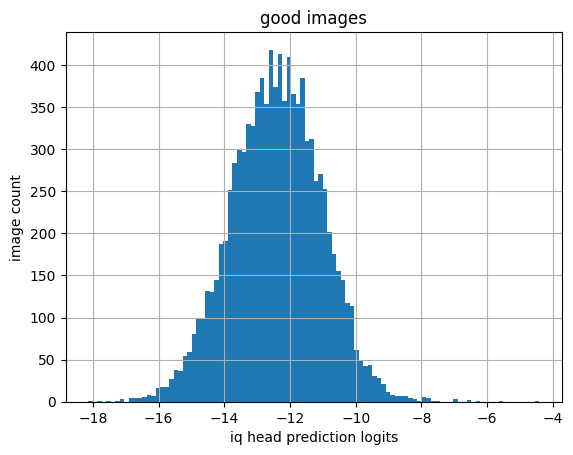

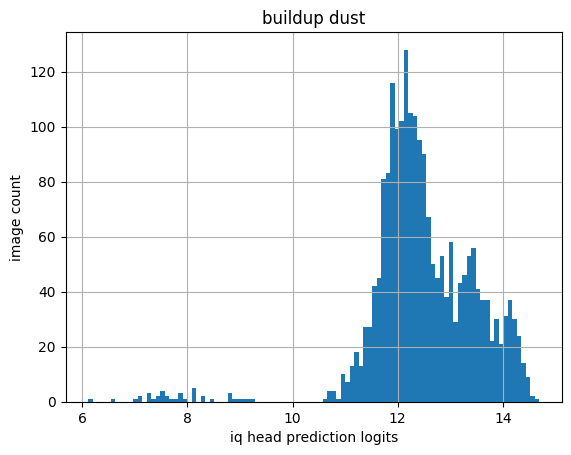

In [40]:
final_df[final_df.iq_label == 'good'].iq_head_prediction.hist(bins=100)
plt.xlabel('iq head prediction logits')
plt.ylabel('image count')
plt.title('good images')
plt.show()
final_df[final_df.iq_label == 'buildup_dust'].iq_head_prediction.hist(bins=100)
plt.xlabel('iq head prediction logits')
plt.ylabel('image count')
plt.title('buildup dust')
plt.show()

## Parse labelbox saved ndjson file

In [27]:
ndjson_file = '/data/jupiter/li.yu/data/halo_fps_cases/dust_night_labelbox_0814_1.ndjson'
df = pd.read_json(ndjson_file, lines=True)
df.shape

(164707, 2)

In [31]:
df['id'] = df.data_row.apply(lambda d: d['global_key'].split(',')[0])
df.head(2)

,data_row,media_attributes,id
0,"{'id': 'clzugds4u3xth0777zvkoef2u', 'external_...","{'height': 1204, 'width': 1944, 'asset_type': ...",668c631ec3254cc83b48ffe6
1,"{'id': 'clzugds4u3xti0777z3wqq39i', 'external_...","{'height': 1204, 'width': 1944, 'asset_type': ...",668c5f3afc75eecba026e35d


## Recover missed human labels in heavy dust images

In [29]:
import os
os.environ['BRT_ENV'] = 'dev'

aws_profile = 'default'
os.environ['AWS_PROFILE'] = aws_profile

from brtdevkit import setup_default_session
setup_default_session(aws_profile=aws_profile)

from brtdevkit.core import LabelPolicy
from brtdevkit.core import Annotation as AnnotationAPI
from brtdevkit.core import AnnotationBatch

ImportError: cannot import name 'Annotation' from 'brtdevkit.core' (/home/li.yu/anaconda3/envs/brtdevkit/lib/python3.9/site-packages/brtdevkit/core/__init__.py)

In [52]:
root_dir = '/data/jupiter/li.yu/data/dust_data_colletion_for_july_1st'
# raw_dataset = 'halo_human_in_dust_day_collection_may29'
raw_dataset = 'halo_human_in_dust_day_collection_back_june05'
labeled_dataset = raw_dataset + '_human_labeled_stereo'
label_dir = os.path.join(root_dir, labeled_dataset)

raw_df = pd.read_csv(os.path.join(root_dir, raw_dataset, 'master_annotations.csv'))
labeled_df = pd.read_csv(os.path.join(root_dir, labeled_dataset, 'master_annotations.csv'))
raw_df.shape, labeled_df.shape

/tmp/ipykernel_2995519/2040107990.py:8: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  labeled_df = pd.read_csv(os.path.join(root_dir, labeled_dataset, 'master_annotations.csv'))


((8740, 150), (3511, 277))

In [53]:
seq_dfs = get_sequences(raw_df, interval=60, per_camera_pair=False)  # break the data by intervals between sequences
print(raw_df.shape, len(seq_dfs))

(8740, 150) 8


In [34]:
def update_missed_label(label_dir, label_image_row, missed_label_image_id):
    # get label image 
    label_img = os.path.join(label_dir, label_image_row.annotation_pixelwise_0_save_path)
    
    values = {
        'kind': 'labelbox', 
        'state': 'labeling', # state must be labeling in order to have the s3 information blank
        'style': 'pixelwise',
        'label_policy': '64a18d8843e37ee6fbff69ef',
        'label_map_full': '64a18dd03e21af0a1b21ede7', # example label map id
        's3_key': '',
        's3_bucket': ''
    }
    annotation = AnnotationAPI(image_id=str(missed_label_image_id), values=values)
    annotation.create()
    
    # Upload the segmentation mask file from your local machine
    annotation.upload(label_img)
    
    # Update the state to ok now that the s3 location is set
    annotation = AnnotationAPI(
        image_id=str(annotation['image']), 
        values={'_id': str(annotation['id']), 'state': 'ok'}
    )
    annotation.update()

In [50]:
def recover_skipped_human_label(data_dir, seq_dfs, suffix, same_human_sequence):
    all_cameras = {'front': ['T01', 'T02', 'T03', 'T04'], 'right': ['T05', 'T06', 'T07', 'T08'], 'back': ['T09', 'T10', 'T11', 'T12'], 'left': ['T13', 'T14', 'T15', 'T16']}

    raw_ms_df = pd.read_csv(os.path.join(data_dir, 'master_annotations.csv'))
    raw_ms_df['camera_pair'] = raw_ms_df['unique_id'].apply(lambda s: s[-7:])
    labeled_ms_df = pd.read_csv(os.path.join(data_dir+suffix, 'master_annotations.csv'))
    labeled_ms_df.drop(columns=["label_counts"], inplace=True)
    labeled_ms_df['camera_pair'] = labeled_ms_df['unique_id'].apply(lambda s: s[-7:])
    print(raw_ms_df.shape, labeled_ms_df.shape)

    updated = set()
    for pod, seq_ids in same_human_sequence.items():
        for seq_id in seq_ids:
            # get seq df in pod
            seq_df = seq_dfs[seq_id]
            seq_df = seq_df[seq_df.camera_location.isin(all_cameras[pod])]
            # get corresponding raw seq df and labeled seq df
            raw_seq_df = raw_ms_df[raw_ms_df.id.isin(seq_df.id)]
            labeled_seq_df = labeled_ms_df[labeled_ms_df.id.isin(seq_df.id)]
            labeled_seq_df = labeled_seq_df.sort_values('collected_on')
            # get camera locations where there are human labels
            labeled_camera_pairs = labeled_seq_df.camera_pair.unique()
            for camera_pair in labeled_camera_pairs:
                raw_seq_cp_df = raw_seq_df[raw_seq_df.camera_pair == camera_pair]
                labeled_seq_cp_df = labeled_seq_df[labeled_seq_df.camera_pair == camera_pair]
                # assign label path to raw df
                for i, row in raw_seq_cp_df.iterrows():
                    labeled_rows = labeled_seq_cp_df[labeled_seq_cp_df.unique_id == row.unique_id]
                    if len(labeled_rows) > 0:
                        # print(pod, seq_id, row.id, 'has label')
                        pass
                    else:
                        # raw_seq_cp_df.loc[i, 'rectified_label_save_path'] = labeled_seq_cp_df.iloc[0].rectified_label_save_path
                        if not row.id in updated:
                            # print(pod, seq_id, row.id, 'update label')
                            # update_missed_label(data_dir+suffix, labeled_seq_cp_df.iloc[0], row.id)
                            updated.add(row.id)
            print(pod, seq_id, len(seq_df), len(raw_seq_df), len(labeled_seq_df), raw_seq_df.camera_pair.unique(), labeled_seq_df.camera_pair.unique())

    updated_df = pd.DataFrame(data={'id': list(updated)})
    print('updated image labels', updated_df.shape)
    # updated_df.to_csv(os.path.join(data_dir, 'updated_skipped_human_label.csv'), index=False)

In [51]:
# recover skipped human labels in heavy dust, by images in the same sequence - halo_human_in_dust_day_collection_may29
same_human_sequence = {'front': [0, 1, 3, 14], 'right': [11, 12, 13], 'back': [7, 8, 9, 10], 'left': [4, 5, 6]}
suffix = '_human_labeled_stereo'
recover_skipped_human_label(os.path.join(root_dir, raw_dataset), seq_dfs, suffix, same_human_sequence)

/tmp/ipykernel_2995519/582401222.py:6: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  labeled_ms_df = pd.read_csv(os.path.join(data_dir+suffix, 'master_annotations.csv'))


(35854, 150) (5967, 275)
front 0 446 446 246 ['T01_T03' 'T02_T03' 'T02_T04'] ['T02_T04' 'T02_T03']
front 1 164 164 74 ['T01_T03' 'T02_T03' 'T02_T04'] ['T02_T04' 'T02_T03']
front 3 108 108 42 ['T01_T03' 'T02_T03' 'T02_T04'] ['T02_T04' 'T02_T03']
front 14 867 867 284 ['T01_T03' 'T02_T03' 'T02_T04'] ['T01_T03' 'T02_T03' 'T02_T04']
right 11 120 120 117 ['T05_T07' 'T06_T08' 'T06_T07'] ['T06_T08' 'T06_T07' 'T05_T07']
right 12 709 709 705 ['T05_T07' 'T06_T08' 'T06_T07'] ['T06_T08' 'T05_T07' 'T06_T07']
right 13 820 820 535 ['T05_T07' 'T06_T08' 'T06_T07'] ['T06_T07' 'T06_T08']
back 7 948 948 943 ['T09_T11' 'T10_T12' 'T10_T11'] ['T10_T11' 'T09_T11' 'T10_T12']
back 8 854 854 558 ['T09_T11' 'T10_T12' 'T10_T11'] ['T10_T12' 'T10_T11']
back 9 332 332 222 ['T09_T11' 'T10_T12' 'T10_T11'] ['T10_T11' 'T10_T12']
back 10 670 670 447 ['T09_T11' 'T10_T12' 'T10_T11'] ['T10_T12' 'T10_T11']
left 4 875 875 805 ['T13_T15' 'T14_T16' 'T14_T15'] ['T14_T16' 'T14_T15' 'T13_T15']
left 5 912 912 502 ['T13_T15' 'T14_T16'

In [54]:
# recover skipped human labels in heavy dust, by images in the same sequence - halo_human_in_dust_day_collection_back_june05
same_human_sequence = {'back': [0, 1, 2, 3, 5, 6, 7]}
suffix = '_human_labeled_stereo'
recover_skipped_human_label(os.path.join(root_dir, raw_dataset), seq_dfs, suffix, same_human_sequence)

/tmp/ipykernel_2995519/582401222.py:6: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  labeled_ms_df = pd.read_csv(os.path.join(data_dir+suffix, 'master_annotations.csv'))


(8740, 151) (3511, 277)
back 0 562 562 184 ['T09_T11' 'T10_T12' 'T10_T11'] ['T09_T11']
back 1 911 911 114 ['T09_T11' 'T10_T12' 'T10_T11'] ['T09_T11']
back 2 186 186 11 ['T09_T11' 'T10_T12' 'T10_T11'] ['T09_T11']
back 3 1102 1102 196 ['T09_T11' 'T10_T12' 'T10_T11'] ['T09_T11']
back 5 1262 1262 576 ['T09_T11' 'T10_T12' 'T10_T11'] ['T10_T12' 'T10_T11']
back 6 1631 1631 967 ['T09_T11' 'T10_T12' 'T10_T11'] ['T10_T11' 'T10_T12']
back 7 1034 1034 687 ['T09_T11' 'T10_T12' 'T10_T11'] ['T10_T12' 'T10_T11']
updated image labels (609, 1)


## Modify distribution items from Pawan's list for train labeling

In [26]:
label_dist_dir = '/data/jupiter/li.yu/data/label_distribution'
full_csv = 'humans_in_snow_generated_scenarios_sorted.csv'
df = pd.read_csv(os.path.join(label_dist_dir, full_csv))
print(df.shape)
df.sample(5)

(454, 6)


,location_index,distance,camera_location,clothing,pose,special_notes
289,59,10m-15m,T01_T03,dark,standing,standing-10m-15m-T01_T03-dark
73,14,5m-10m,T13_T15,dark,standing,standing-5m-10m-T13_T15-dark
151,30,20m-22m,T06_T07,light,standing,standing-20m-22m-T06_T07-light
5,1,10m-15m,T09_T11,dark,laying_down,laying_down-10m-15m-T09_T11-dark
201,40,15m-20m,T05_T07,dark,standing,standing-15m-20m-T05_T07-dark


In [6]:
print(df.distance.unique())
print(df.clothing.unique())
print(df.pose.unique())
print(df.camera_location.unique())

['10m-15m' '15m-20m' '5m-10m' '20m-22m']
['camo' 'dark' 'white' 'light']
['standing' 'laying_down' 'crouching']
['T09_T11' 'T13_T15' 'T01_T03' 'T02_T03' 'T10_T12' 'T06_T08' 'T02_T04'
 'T14_T16' 'T10_T11' 'T14_T15' 'T05_T07' 'T06_T07']


In [27]:
# reduce scenarios for training
# remove all close distance items
df = df[(df.distance != '5m-10m')]
df = df[(df.distance != '10m-15m')]
print(df.shape)
# for medium distance, just keep crouching and laying_down poses
_df = df[(df.distance == '15m-20m') & (df.pose == 'standing')]
df = df[~df.special_notes.isin(_df.special_notes)]
print(df.shape)
# change 20m-22m to 20m-25m
df.loc[df.distance == '20m-22m', 'distance'] = '20m-25m'
print(df.shape)
# reduce camera positions
front_back_cameras = ['T09_T11', 'T01_T03', 'T02_T03', 'T10_T12', 'T02_T04', 'T10_T11']
left_right_cameras = ['T13_T15', 'T06_T08', 'T14_T16', 'T14_T15', 'T05_T07', 'T06_T07']
front_back_ratio = 2/3
left_right_ratio = 1/3
df1 = df[df.camera_location.isin(front_back_cameras)]
df1 = df1.sample(n=int(len(df1)*front_back_ratio))
df2 = df[df.camera_location.isin(left_right_cameras)]
df2 = df2.sample(n=int(len(df2)*left_right_ratio))
df = pd.concat([df1, df2], ignore_index=True)
print(df.shape)

(195, 6)
(66, 6)
(66, 6)
(32, 6)


In [28]:
df.sample(5)

,location_index,distance,camera_location,clothing,pose,special_notes
24,69,20m-25m,T06_T08,dark,standing,standing-20m-22m-T06_T08-dark
23,30,20m-25m,T06_T07,light,standing,standing-20m-22m-T06_T07-light
2,63,20m-25m,T09_T11,white,standing,standing-20m-22m-T09_T11-white
28,52,20m-25m,T14_T15,camo,standing,standing-20m-22m-T14_T15-camo
30,28,20m-25m,T14_T15,white,laying_down,laying_down-20m-22m-T14_T15-white


In [29]:
lite_csv = 'humans_in_snow_generated_scenarios_train.csv'
df.to_csv(os.path.join(label_dist_dir, lite_csv), index=False)

## Check for 2023 and 2024 Spring paid pilot stop events

In [8]:
df.robot_name.unique()

array(['loamy_05', 'unknown', 'loamy_06', 'peaty_03', 'peaty_04',
       'peaty_02', 'loamy_07', 'loamy_812', 'loamy_04', 'hitchhiker_07',
       'loamy_735', 'loamy_733', 'loamy_752', 'loamy_204', 'loamy_756',
       'loamy_253', 'loamy_909', 'loamy_851', 'loamy_869', 'loamy_731',
       'loamy_799', 'loamy_842', 'triton_01', 'hh_17', 'peaty_6',
       'peaty_07', 'peaty_05', 'loamy_817', 'hitchhiker_03',
       'hitchhiker_30', 'hitchhiker_31', 'hitchhiker_22', 'hitchhiker_21',
       'hitchhiker_18', 'hitchhiker_35', 'hitchhiker_19', 'hitchhiker_20',
       'hitchhiker_32', 'loamy_6', 'hitchhiker_41', 'hitchhiker_04',
       'hitchhiker_29', 'loamy_869_1', 'loamy_869_0', 'hitchhiker_05',
       'hitchhiker_25', 'hitchhiker_15', 'hitchhiker_14', 'hitchhiker_46',
       'hitchhiker_16', 'hitchhiker_26', 'loamy_768', 'loamy_851_1',
       'loamy_83', 'hitchhiker_23', 'hitchhiker_12', 'loamy_710',
       'loamy_851_0', 'hitchhiker_47', 'hitchhiker_42', 'hitchhiker_38',
       'hitchhike

In [22]:
def print_time(df):
    df = df.sort_values('collected_on')
    for i in range(0, len(df), len(df)//5):
        print(df.iloc[i].collected_on, df.iloc[i].id, df.iloc[i].special_notes)
print_time(df3)

2024-03-09 15:43:12.793000+00:00 661897a24eb730b31c877233 nan
2024-03-13 18:15:37.343000+00:00 6626bcf55173fcbaa5260399 nan
2024-03-15 15:27:04.831000+00:00 6618880a9c1e66fc8aacc049 nan
2024-03-18 22:44:46.478000+00:00 661892dfe3421996ec0f01d5 nan
2024-03-20 15:55:59.425000+00:00 66189722a51d194ffe7b4758 nan
2024-03-28 17:16:51.267000+00:00 66189638aca156e5dae8934d nan


In [24]:
df2 = df[df.collected_on.str.startswith('2024')]
df2.shape

(1187, 486)

In [25]:
df2.robot_name.unique()

array(['loamy_83', 'loamy_735', 'loamy_752', 'loamy_204', 'loamy_869',
       'loamy_756', 'loamy_799', 'loamy_872', 'loamy_768', 'loamy_851',
       'loamy_842', 'loamy_710', 'loamy_731', 'loamy_646', 'loamy_812',
       'loamy_909', 'loamy_619', 'loamy_750', 'loamy_817'], dtype=object)

In [16]:
df3 = df2[(~df2.teleop_request.isna())]
df3.shape

(1187, 486)

In [15]:
'teleop_request' in df2

True

In [ ]:
spark_program_ids = [
    'df107166-9e1d-488b-ae2e-0ef48149aee4',  # 2023 Spring Misuse?
    '62c0cc50-ef3b-4983-873a-01a86513c25b',  # 2023 Spring Paid Pilot
    '6bc86c38-15de-430d-be47-ca92c1d8130b',  # 2024 Spring Paid Pilot
    'bf7011c9-56a3-4412-99b9-d7e7de75b33c',  # 2024 Fall Rev2 stops
]

In [28]:
stop_dir = '/data/jupiter/li.yu/data/halo_fps_cases/'
stop_csvs = ['aletheia_stops_202403.csv', 'aletheia_stops_202404.csv', 'aletheia_stops_202405.csv', 'aletheia_stops_202406.csv']
stop_df = pd.concat([pd.read_csv(os.path.join(stop_dir, csv)) for csv in stop_csvs], ignore_index=True).drop_duplicates(subset='id')
print(stop_df.shape)
REV1_LEFT_CAMERAS = ['front-center-left', 'front-left-left', 'front-right-left', 'side-left-left', 'side-right-left', 'rear-left']
stop_df = stop_df[stop_df.camera_location.isin(REV1_LEFT_CAMERAS)]
print(stop_df.shape)

(15939, 14)
(7291, 14)


In [30]:
stop_df.robot_name.unique()

array(['loamy_83', 'loamy_6', 'loamy_204', 'loamy_799', 'loamy_752',
       'loamy_735', 'loamy_731', 'loamy_869', 'loamy_851', 'loamy_756',
       'loamy_842', 'loamy_768', 'loamy_872', 'loamy_710', 'loamy_646',
       'loamy_812', 'loamy_909', 'loamy_708', 'loamy_750', 'loamy_619',
       'loamy_817'], dtype=object)

In [31]:
df2[df2.id.isin(stop_df.id)].shape

(1187, 486)

In [32]:
df3 = stop_df[~stop_df.id.isin(df.id)]
df3.shape

(6104, 14)

In [33]:
print_time(df3)

2024-03-13 13:05:09.199000+00:00 66189640485bea94931be53b nan
2024-04-15 20:50:14.121000+00:00 661d9f58b89c97c23b6ef76e nan
2024-04-26 15:38:35.489000+00:00 662bcf67ebcc53890deda9bc nan
2024-05-11 16:19:56.293000+00:00 663fcf08321f043ed7ae12db nan
2024-05-15 13:01:13.184000+00:00 6644f885e99c92d12319cd59 nan
2024-06-10 20:55:07.394000+00:00 666870debb9e6e497e4c7331 nan


In [34]:
df3.to_csv(os.path.join(stop_dir, 'rev1_2024_sring_stops_not_in_train.csv'), index=False)

In [37]:
df3.special_notes.unique()

array([nan], dtype=object)

In [43]:
df3.sample(5)

,id,operation_time,camera_location,frame_id,robot_name,collected_on,special_notes,hard_drive_name,spark_request__json,teleop_request__json,gps_can_data__json,geohash,autonomy_state__json,collected_on_str
10888,6635974d321f043ed7a935d7,daytime,front-left-left,NaN,loamy_842,2024-05-02 19:37:58.584000+00:00,NaN,jdb_harddrive,NaN,NaN,"{""altitude"": 203.2934587, ""bearing"": 89.757812...",dp2735j5jhyt,NaN,2024-05-02 19:37:58
17016,6660a0f1fc5823dda10f12ef,daytime,front-right-left,NaN,loamy_909,2024-06-05 11:10:31.461000+00:00,NaN,jdb_harddrive,NaN,NaN,"{""altitude"": 298.8256865, ""bearing"": 185.60937...",dphwgt494byv,NaN,2024-06-05 11:10:31
4303,661aae2101f52576a9561f9e,daytime,front-left-left,NaN,loamy_768,2024-04-13 14:11:35.594000+00:00,NaN,jdb_harddrive,NaN,NaN,"{""altitude"": 190.0625024, ""bearing"": 77.046875...",dp0585scr69e,NaN,2024-04-13 14:11:35
8668,6640d50688a67985d42b0f10,daytime,front-center-left,NaN,loamy_842,2024-05-11 17:19:09.597000+00:00,NaN,jdb_harddrive,NaN,NaN,"{""altitude"": 229.5659205, ""bearing"": 270.67187...",dp27v8ndydm4,NaN,2024-05-11 17:19:09
10100,663ff25288a67985d42ad3ad,daytime,front-right-left,NaN,loamy_842,2024-05-11 16:49:53.181000+00:00,NaN,jdb_harddrive,NaN,NaN,"{""altitude"": 231.2685554, ""bearing"": 88.796875...",dp27vb03uy45,NaN,2024-05-11 16:49:53


In [41]:
df3[df3.teleop_request__json.isna()].shape

(5869, 14)

In [44]:
df2.shape

(1187, 486)

In [46]:
df2[['has_nearby_stop_event', 'teleop_request']].sample(10)

,has_nearby_stop_event,teleop_request
294520,True,{'jupiter_header_timestamp_epoch': 17140141565...
296626,True,{'jupiter_header_timestamp_epoch': 17164738559...
294336,True,{'jupiter_header_timestamp_epoch': 17128537863...
294871,True,{'jupiter_header_timestamp_epoch': 17156981416...
296275,True,{'jupiter_header_timestamp_epoch': 17160803989...
296128,True,{'jupiter_header_timestamp_epoch': 17146633831...
295318,True,{'jupiter_header_timestamp_epoch': 17161413472...
294815,True,{'jupiter_header_timestamp_epoch': 17154651012...
296417,True,{'jupiter_header_timestamp_epoch': 17161479121...
296358,True,{'jupiter_header_timestamp_epoch': 17154523494...


In [47]:
df2[df2.has_nearby_stop_event == True].shape

(1187, 486)